In [23]:
## Import packages to read in data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as seabornInstance 
import datetime
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

%matplotlib inline

In [2]:
%%time

## Data does not have column headers, add these when importing

column_labels = ['transaction_ID', 'price', 'transfer_date', 'postcode','property_type', 
              'new_build','duration', 'PAON', 'SAON', 'street', 'locality', 'town_city', 
              'district', 'county', 'PPD_category_type', 'record_status']

## Read in the UK Housing Prices Paid 2018 dataset
## requires chunking as it is a large file

df_chunk = pd.read_csv("/Users/user/Desktop/Datasets/pp-2018.csv", names=column_labels,
                      iterator=True, chunksize=10000)

## concatenate the chunks into one DataFrame 
chunk_list = []  # append each chunk here 

# Each chunk is in df format
for chunk in df_chunk:      
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk)
    
# concat the list into dataframe 
df = pd.concat(chunk_list)

CPU times: user 8.23 s, sys: 1.33 s, total: 9.56 s
Wall time: 10.6 s


In [3]:
## As we are interested in only selected columns, restructure the data for these columns
## exclude transaction ID, secondary address (SAON), PPD category type, and record status
df = df.drop(columns = ['transaction_ID', 'SAON', 'PPD_category_type', 'record_status'])

In [4]:
## Convert transfer date to DateTime object
df['transfer_date'] = pd.to_datetime(df.transfer_date)

## Add month and year columns
df['month'] = df['transfer_date'].dt.month
df['year'] = df['transfer_date'].dt.year

df.describe()

,price,month,year
count,1.023150e+06,1.023150e+06,1023150.0
mean,3.497070e+05,6.775684e+00,2018.0
std,1.876659e+06,3.371084e+00,0.0
min,1.000000e+00,1.000000e+00,2018.0
25%,1.450000e+05,4.000000e+00,2018.0
50%,2.300000e+05,7.000000e+00,2018.0
75%,3.550000e+05,1.000000e+01,2018.0
max,5.692000e+08,1.200000e+01,2018.0


### Summary of key statistics

Total number of homes sold in 2018: 1,023,150
Overall 2018 average price was : £349,707
Overall 2018 median price was : £230,000
Average 2018 price paid in London was: £1,019,656


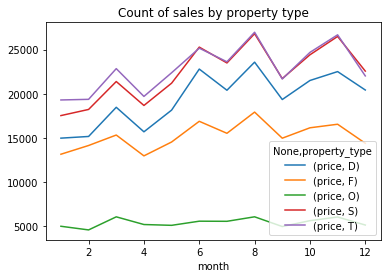

In [5]:
## Summary statistics of dataset
avg_price = np.mean(df.price)
median_price = np.median(df.price)
year_select = 2018
sales_count = len(df.year == year_select)

## Key summary statistics and print out
print("Total number of homes sold in " + str(year_select) + ": " + format(sales_count, ","))
print("Overall 2018 average price was : £" + format(avg_price, ",.0f"))
print("Overall 2018 median price was : £" + format(median_price, ",.0f"))

## Average price paid in London
city_select = 'London'
avg_price_paid = round(df[df.town_city == city_select.upper()].price.mean(), 2)
print("Average 2018 price paid in " + city_select + " was: £" + format(avg_price_paid, ",.0f"))

## Graphing homes sold over time during the year
count_by_month = df[['month','property_type','price']].groupby(['month', 'property_type']).count()
count_by_month = count_by_month.unstack().plot(kind='line', legend=True, 
                                               title='Count of sales by property type')

### Viewing the dataset by selecting criteria

In [6]:
## Explore the data with different criteria
criteria01 = df.price > 1000000
criteria02 = df.new_build == 'Y'

## Return a table, with selected columns, based on those criteria
df_query = df[criteria01 & criteria02].reset_index()
df_query[['price', 'property_type', 'new_build', 'town_city']].head()

,price,property_type,new_build,town_city
0,1325000,D,Y,BISHOP'S STORTFORD
1,1250000,D,Y,HARPENDEN
2,1425000,D,Y,BISHOP'S STORTFORD
3,1150000,F,Y,WINCHESTER
4,1200000,D,Y,BISHOP'S STORTFORD


### Compare multiple cities prices paid

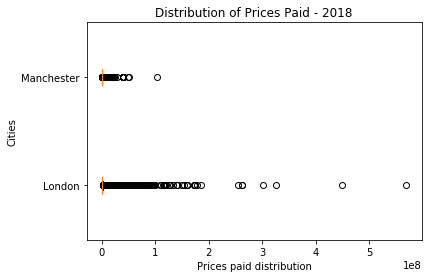

In [7]:
city_option01 = 'London'
city_option02 = 'Manchester'

city01 = df[df['town_city'] == city_option01.upper()]
city02 = df[df['town_city'] == city_option02.upper()]

plt.boxplot([city01.price, city02.price], labels=[city_option01, city_option02], 
            autorange=True, widths=0.15, vert=False)
plt.title('Distribution of Prices Paid - 2018')
plt.xlabel('Prices paid distribution')
plt.ylabel('Cities')
plt.show()

### For predictive modelling, first we will preprocess the data to ensure it can by properly read by the scikit-learn packge. This involves converting ordinal (categorical) data into numerical data.

In [8]:
## Create new columns to enumerate the string data in Property Type and New Build columns
prep_prop_type = {'D' : 1, 
                  'S' : 2, 
                  'T' : 3, 
                  'F' : 4, 
                  'O' : 5}

prep_new_build = {'N': 0, 
                  'Y': 1}

df['prep_prop_type'] = [prep_prop_type[x] for x in df.property_type]
df['prep_new_build'] = [prep_new_build[x] for x in df.new_build]

### Also, we need to generalize the postcodes by removing the last 3 letters to provide a better geographical grouping (6-7 character postcodes are overly specific)

In [9]:
## Create new column that trims the postcodes into generalized postcodes (remove last 4 charaacters)
df['trim_postcode'] = [str(x)[:-4] for x in df.postcode.tolist()]

# Create a new dictionary of only unique generalized postcodes
p = df.trim_postcode.unique()
unique_postcodes = dict(np.ndenumerate(p))
# Flip the keys and values to get a numerical value for each unique generalized postcode
unique_postcodes = {y:x for x,y in unique_postcodes.items()}

# Assign the unique number of postcode to each instance (or row) in DataFrame
df['prep_postcode'] = [unique_postcodes[x] for x in df.trim_postcode]
# Then trim the values of non-numerical characters
df['prep_postcode'] = [str(x)[1:-2] for x in df['prep_postcode']]
# To convert it to an integer for use in the model
df['prep_postcode'].astype(int).head()

0    0
1    1
2    2
3    3
4    4
Name: prep_postcode, dtype: int64

In [43]:
#enc = OneHotEncoder(categorical_features=[1])

X = df[['price', 'prep_postcode', 'prep_new_build', 'prep_prop_type']]
OneHotEncoder().fit_transform(X)
X.head()

,price,prep_postcode,prep_new_build,prep_prop_type
0,770000,0,0,1
1,253500,1,0,1
2,231950,2,1,1
3,112500,3,0,2
4,184995,4,1,2


### Assign the data to the scikit-learn regression packages, starting with multivariate analysis

In [ ]:
## Multiple linear regression - packages have been imported above
X = df[['prep_prop_type', 'prep_new_build', 'prep_postcode']].astype(int)
y = df.price

## Set the training parameters
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train the model
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

## Find the coefficients of the variables
coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
coeff_df

## Perform a prediction on the test data
y_pred = regressor.predict(X_test)

## Check the difference between actual and predicted
df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df1.head(25)

## Next we plot the results
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

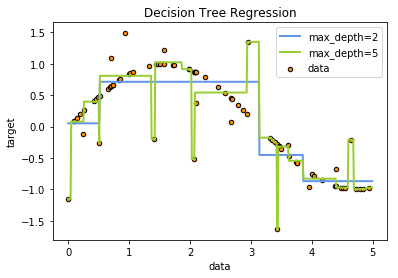

In [129]:
## Decision Tree regression model
# Import the necessary modules and libraries
from sklearn.tree import DecisionTreeRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

# Predict
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

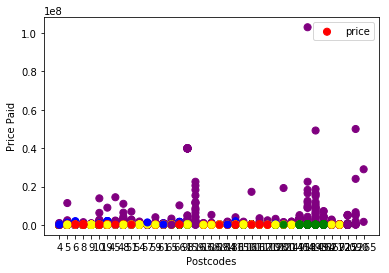

In [83]:
# City for graph
city = 'Manchester'

# number representing size
x1 = df[df['town_city'] == city.upper()].prep_postcode

# generate array of property types
x2 = df[df['town_city'] == city.upper()].property_type

# number representing price
y = df[df['town_city'] == city.upper()].price

# create mapping from property type to matplot colour
property_type_colour_map = {'D' : 'blue', 
                            'S' : 'red', 
                            'T' : 'yellow', 
                            'F' : 'green', 
                            'O' : 'purple'}

# create array of colours from list comprehension
colour_array = [property_type_colour_map[i] for i in x2]

plt.scatter(x1, y, c=colour_array, s=50)
plt.xticks()
plt.yticks()
plt.xlabel('Postcodes')
plt.ylabel('Price Paid')
plt.legend()
plt.show()